## EDO 3
### Visualizando linhas de campo

A visualização de linhas de campo é fundamental na comprehensão do conceito mesmo de campo vectorial. 

Em termos matematicos, as linhas de campo são linhas contínuas cuja tangente em cada ponto é dada por um campo vetorial.  Cada linha pode ser caracterizada por um parametro $k$ e obedece a equação.

$$
\frac{d {\bf r}}{dk} = g(k) {\bf E}({\bf r}(k)), 
$$


Onde ${\bf E}({\bf r}(k))$ é o campo vetorial (e.g., campos gravitacional, eletrico, magnetico ou de velocidades) e $g(k)$ uma função de escala (ou de normalização).  Essa função determina que tão rápido se anda ao longo da linha de campo como função do parametro $k$.  Convenientemente usamos:

$$
g(t) = \frac{1}{|{\bf E}({\bf r}(k))|}
$$

`python.matplotlib` já vem com uma função para graficar linhas de campo, vamoa a utilizar essa função mas também vamos resolver a equação acima para criar a nossa propria rotina.

Vamos graficar linhas de campo elétrico para diferentes distribuições de carga:


In [1]:
import matplotlib.pylab as plt
import numpy as np
from scipy.integrate import ode

In [2]:
# classe para criar cargas eletricas
class carga:
    def __init__(self,q,pos):
        self.q = q
        self.pos = pos
    
def E_carga_pontual(q,a,x,y):
    return q*(x-a[0])/((x-a[0])**2+(y-a[1])**2)**(1.5), \
        q*(y-a[1])/((x-a[0])**2+(y-a[1])**2)**(1.5)

def E_total(x,y,cargas):
    Ex, Ey=0, 0
    for C in cargas:
        E = E_carga_pontual(C.q, C.pos, x, y)
        Ex=Ex+E[0]
        Ey=Ey+E[1]
    return [Ex, Ey]

In [3]:
# usamos as funçoes acima para definir cargas e posicoes
cargas = [carga(1, [-1, 0]), carga(-1, [1, 0])]

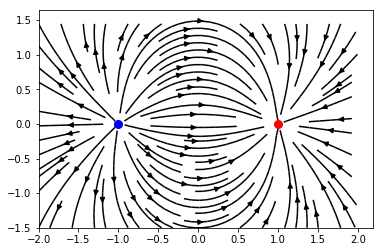

In [4]:
# graficamos as linhas de campo
x0, x1=-2, 2
y0, y1=-1.5, 1.5
x=np.linspace(x0, x1, 64)
y=np.linspace(y0, y1, 64)
x, y=np.meshgrid(x, y)
Ex, Ey=E_total(x, y, cargas)
# linhas de campo usando streamplot
plt.streamplot(x,y,Ex,Ey,color='k')

#cargas pontuais
for C in cargas:
    if C.q>0:
        plt.plot(C.pos[0],C.pos[1],'bo',ms=8*np.sqrt(C.q))
    if C.q<0:
        plt.plot(C.pos[0],C.pos[1],'ro',ms=8*np.sqrt(-C.q))

A função streamplot é generica e facil de usar, no entanto, ela não reconhece as características do campo vetorial que queremos disenhar. Por exemplo, ela não entende que as linhas de campo sempre saem das cargas. Vamos resolver a equação das linhas de campo, que para o caso das cargas elétricas é um sistema de 2 EDO. 

In [3]:
def rk4vec( t0, m, u0, dt, f ):
    
    import numpy as np
    
    f0 = f ( t0, m, u0 )
    t1 = t0 + dt / 2.0
    u1 = np.zeros ( m )
    u1[0:m] = u0[0:m] + dt * f0[0:m] / 2.0
    f1 = f ( t1, m, u1 )
    
    t2 = t0 + dt / 2.0
    u2 = np.zeros ( m )
    u2[0:m] = u0[0:m] + dt * f1[0:m] / 2.0
    f2 = f ( t2, m, u2 )
    
    t3 = t0 + dt
    u3 = np.zeros ( m )
    u3[0:m] = u0[0:m] + dt * f2[0:m]
    f3 = f ( t3, m, u3 )
    
    u = np.zeros ( m )
    u[0:m] = u0[0:m] + ( dt / 6.0 ) * ( \
                                       f0[0:m] \
                                       + 2.0 * f1[0:m] \
                                       + 2.0 * f2[0:m] \
                                       +       f3[0:m] )
    return u

In [6]:
def E_f(t, m, u):
    cargas = [carga(1, [-1, 0]), carga(-1,[-1,1]), carga(1,[1,1]), carga(-1, [1, 0])]
    #cargas = [carga(1, [-1, 0]), carga(1,[1,1]), carga(-1, [1, 0])]
    #cargas = [carga(1,[-1,0])]
    uprime = np.zeros_like(u)
    #Ex e Ey 
    Ex, Ey = E_total(u[0], u[1], cargas)
    n=np.sqrt(Ex**2+Ey*Ey)
    
    uprime[0] = Ex/n
    uprime[1] = Ey/n
    
    return uprime

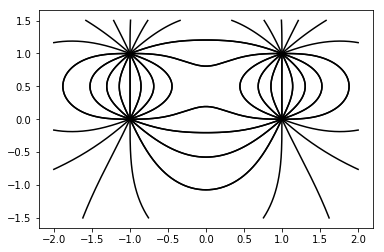

In [7]:
# Limites do gráfico
x0, x1=-2, 2
y0, y1=-1.5, 1.5
R=0.01
# o número de equações para o caso bidimensional é 2
m = 2
u0 = np.zeros([m])
u1 = np.zeros_like(u0)

# loop sob as cargas conta
# conta sob o numero de elementos no vetor cargas
cargas = [carga(1, [-1, 0]), carga(-1,[-1,1]), carga(1,[1,1]), carga(-1, [1, 0])]
#cargas = [carga(1, [-1, 0]), carga(1,[1,1]), carga(-1, [1, 0])]
for C in cargas:
    # Começamos a graficar começando na carga
    dt=0.8*R
    if C.q<0:
        dt=-dt
    # loop over field lines starting in different directions 
    # around current charge
    for alpha in np.linspace(0, 2*np.pi*15/16, 16):
        x=[ C.pos[0] + np.cos(alpha)*R ]
        y=[ C.pos[1] + np.sin(alpha)*R ]
        
        u0[0] = x[0]
        u0[1] = y[0]
        t0 = 0.
        # agora chamamos nosso integrador RK4
        
        while (True):
            t1 = t0 + dt
            u1 = rk4vec( t0, m, u0, dt, E_f)
            
            t0 = t1
            x.append(u1[0])
            y.append(u1[1])
            
            u0 = np.copy(u1)
            
            hit_charge=False
            # check if field line left drwaing area or ends in some charge
            for C2 in cargas:
                if np.sqrt((u1[0]-C2.pos[0])**2+(u1[1]-C2.pos[1])**2)<R:
                    hit_charge=True
            if hit_charge or (not (x0<u1[0] and u1[0]<x1)) or (not (y0<u1[1] and u1[1]<y1)):
                break
                    
                    
        plt.plot(x, y, '-k')